# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# additional libraries
import matplotlib.ticker as mtick
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the AZDIAS dataset after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('The number of samples of the AZDIAS data is', azdias.shape[0])
print('The number of features of the AZDIAS data is', azdias.shape[1])

The number of samples of the AZDIAS data is 891221
The number of features of the AZDIAS data is 85


In [4]:
# Print the first 5 rows of the AZDIAS dataset
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Preview the AZDIAS dataset
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
# Check the structure of the feature summary dataset after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('The number of samples of the feature summary is', feat_info.shape[0])
print('The number of columns of the feature summary is', feat_info.shape[1])

The number of samples of the feature summary is 85
The number of columns of the feature summary is 4


In [7]:
# print the feature summary dataset
print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [8]:
#preview the feature summary dataset
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify how much data is naturally missing
data_naturally_missing = azdias.isna().sum().sum()
print('The number of data naturally missing is', data_naturally_missing)

The number of data naturally missing is 4896838


In [10]:
# Identify and convert data that matches 'missing' or 'unknown' value code in feature summary dataset into a numpy NaN value.

# Loop through the samples in the feature summary dataset, parse the values in the missing_or_unknown feature by 
# removing the [] and split the individual data back into the column
for idx in range(feat_info.missing_or_unknown.count()):
    feat_info.missing_or_unknown[idx] = feat_info.missing_or_unknown[idx].strip('[]').split(',')
    
    # Loop through the individual data in the list for the sample. If the data is an integer format, 
    # convert the string into integer.
    # If the data is not an integer format, exception is raised. Continue the loop and keep the string format.
    for item in range(len(feat_info.missing_or_unknown[idx])):
        try:
            feat_info.missing_or_unknown[idx][item] = int(feat_info.missing_or_unknown[idx][item])
        except:
            continue
    
    # Convert the samples in the azdias dataset that matches the value in the missing_or_unknown column into a numpy NaN value.
    azdias.iloc[:, idx].replace(feat_info.missing_or_unknown[idx], np.nan, inplace=True)             

In [11]:
# Identify the total number of NAN values in the AZDIAS dataset after conversion
total_nan_values = azdias.isna().sum().sum()
print('The total number of NAN values in the AZDIAS dataset is', total_nan_values)

The total number of NAN values in the AZDIAS dataset is 8373929


In [12]:
# Identify the number of data with missing or unknown code that matches the feature summary dataset
data_missing_unknown = total_nan_values - data_naturally_missing
print('The number of data with missing or unknown code is', data_missing_unknown)

The number of data with missing or unknown code is 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the dataset.
# Sort the values in descending order
missing_data_columns = azdias.isna().sum().sort_values(ascending=False)
print(missing_data_columns)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

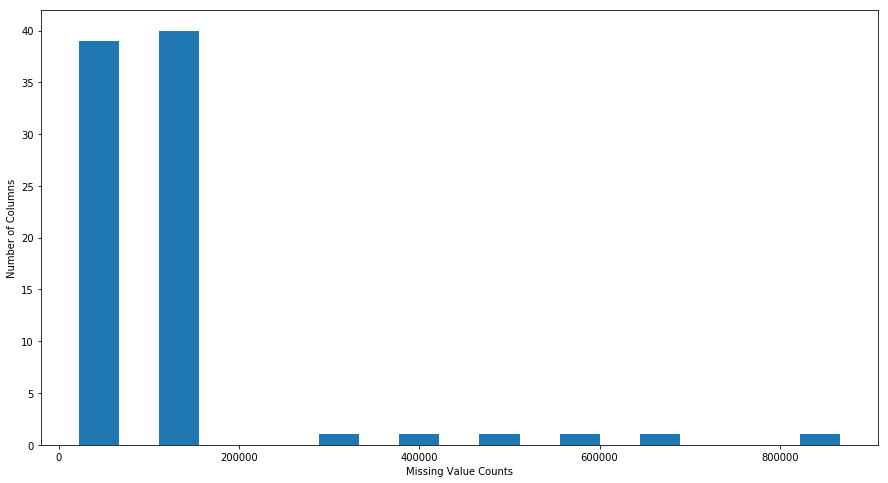

In [14]:
# Plot the histogram to visualize the distribution of missing value counts in the dataset
plt.figure(figsize=(15,8))
plt.hist(missing_data_columns, rwidth=0.5)
plt.ylabel("Number of Columns")
plt.xlabel("Missing Value Counts")
plt.show()

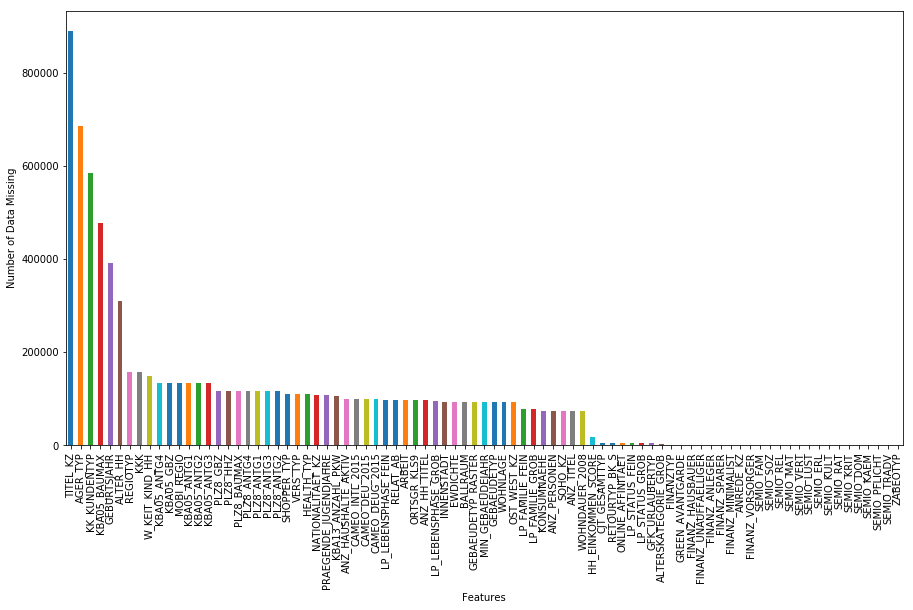

In [15]:
# Investigate patterns in the amount of missing data in each feature.
plt.figure(figsize=(15,8))
missing_data_columns.plot.bar()
plt.xlabel('Features')
plt.ylabel('Number of Data Missing')
plt.show()

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# From the histogram above, the outlier are the features with more than 200,000 missing value counts.
# From the bar graph above, I am able to identify there are 6 features with more than 200,000 missing value counts.
# The 6 columns are TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR and ALTER_HH.
# Remove the 6 features from the dataset.

azdias.drop(columns=['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], inplace=True)

In [17]:
print('AZDIAS dataset new shape is', azdias.shape)

AZDIAS dataset new shape is (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram above, I noticed that the outliers are features with more than 200,000 missing value counts. After further investigation with the bar graph above, I am able to identify that there are 6 features with more than 200,000 missing value counts.

These 6 outliers features are TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR and ALTER_HH. Therefore, they are removed from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
missing_data_rows = azdias.isna().sum(axis=1)
print(missing_data_rows)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


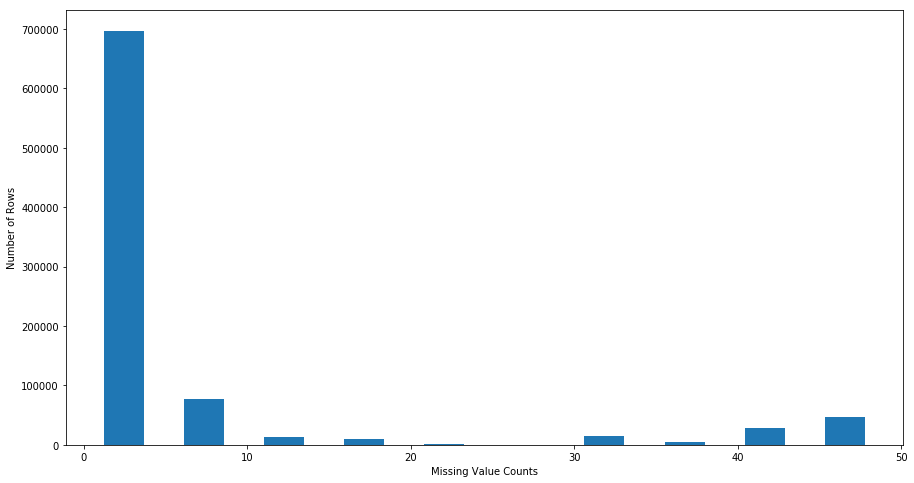

In [19]:
# Plot the histogram to visualize the distribution of missing value counts in the dataset
plt.figure(figsize=(15,8))
plt.hist(missing_data_rows, rwidth=0.5)
plt.ylabel("Number of Rows")
plt.xlabel("Missing Value Counts")
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

#From the histogram above, we can select the threshold as 10
THRESHOLD = 10
azdias_above_threshold, azdias_below_threshold = [x for _, x in azdias.groupby(missing_data_rows <= THRESHOLD)]

In [21]:
print('There are', azdias_above_threshold.shape[0], 'samples above threshold of', THRESHOLD, 'missing value counts')

There are 111068 samples above threshold of 10 missing value counts


In [22]:
print('There are', azdias_below_threshold.shape[0], 'samples below threshold of', THRESHOLD, 'missing value counts')

There are 780153 samples below threshold of 10 missing value counts


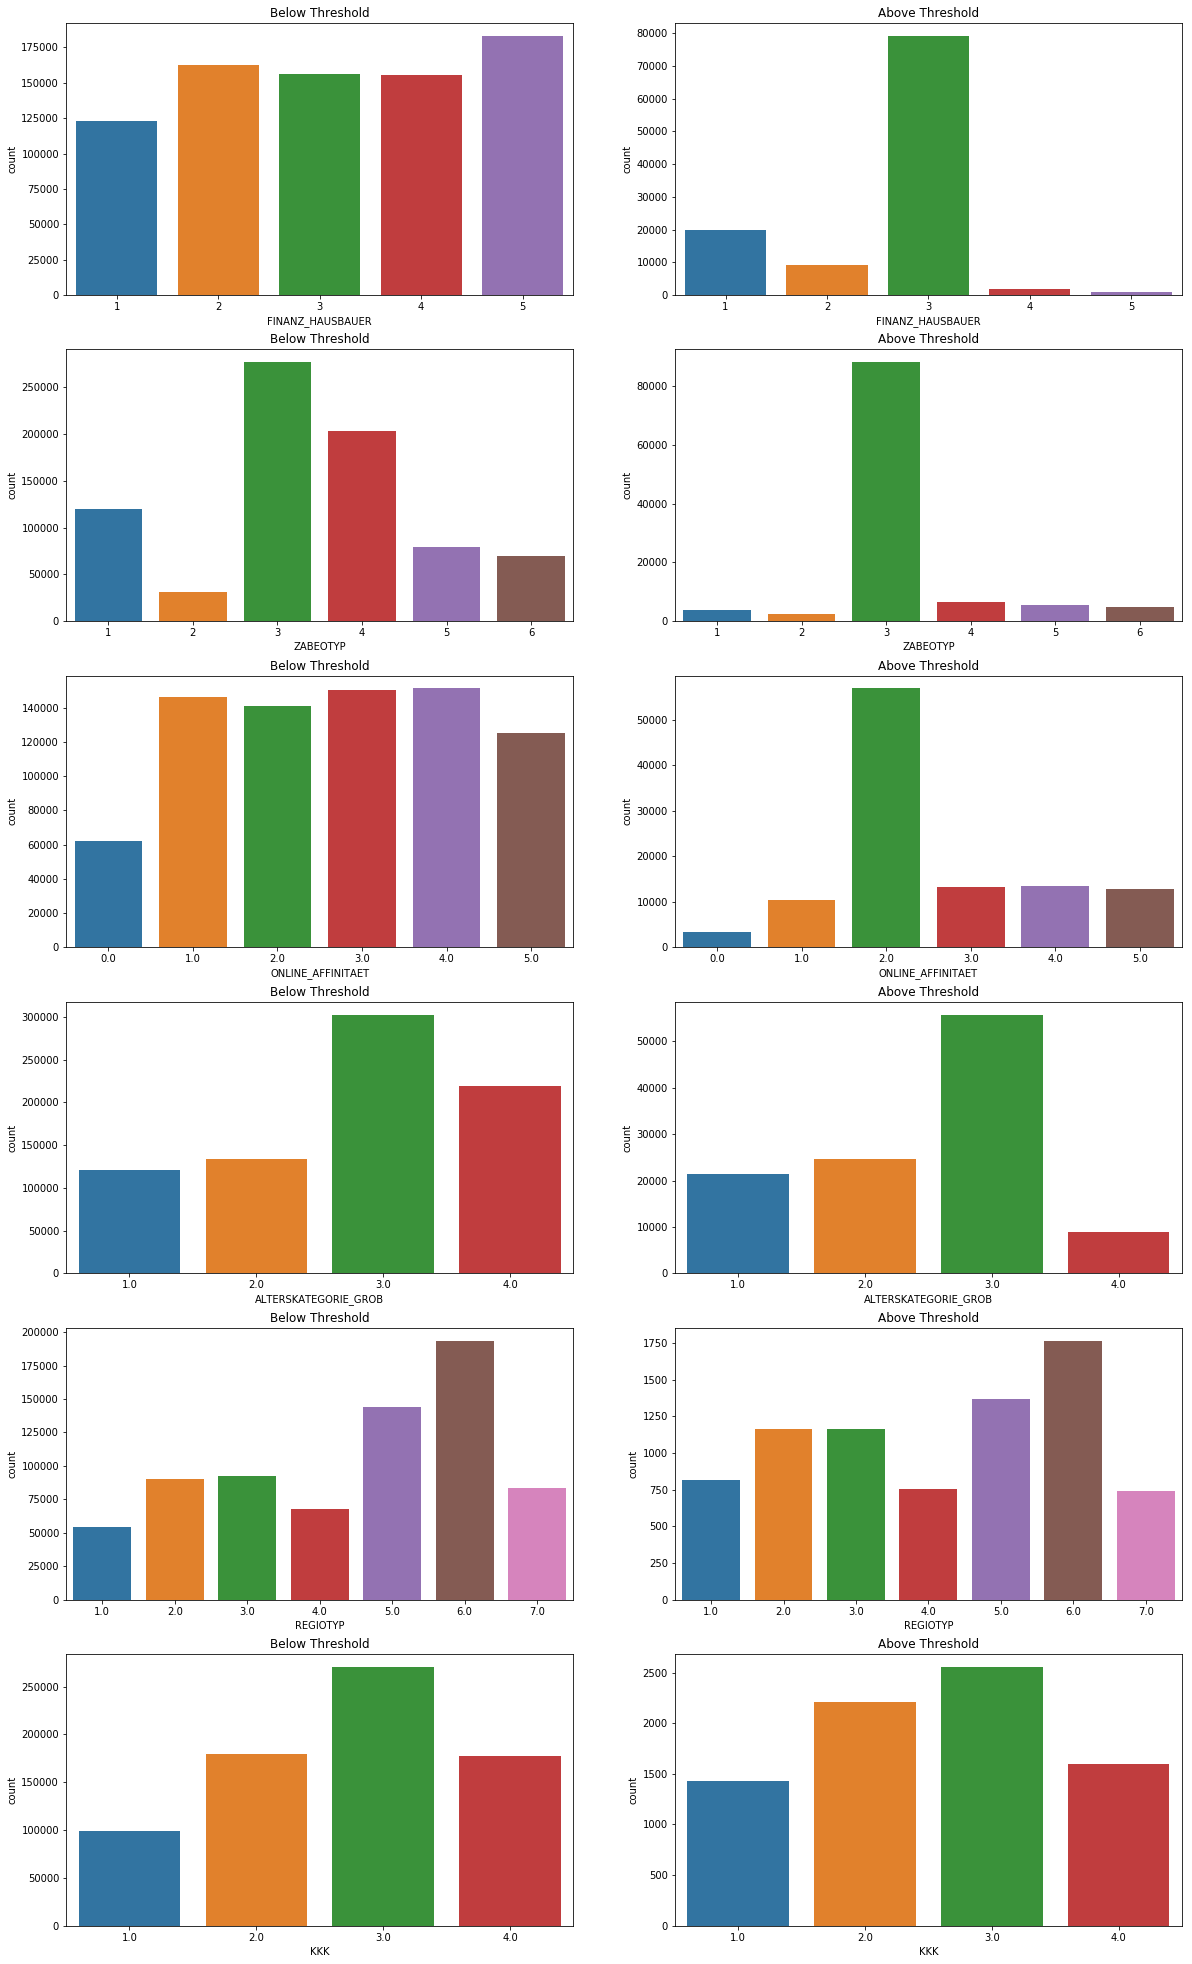

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# From the bar graph above, selected 2 features x no missing values, 2 features x few missing values 
# and 2 features x many missing values
FEATURES_NAMES = ['FINANZ_HAUSBAUER','ZABEOTYP', 'ONLINE_AFFINITAET', 'ALTERSKATEGORIE_GROB', 'REGIOTYP', 'KKK']

fig, axs = plt.subplots(len(FEATURES_NAMES), 2, figsize=(20, 35))
for idx, feature in enumerate(azdias_below_threshold[FEATURES_NAMES]):    
    sns.countplot(x=feature, data=azdias_below_threshold, ax=axs[idx][0]).set_title("Below Threshold")
    sns.countplot(x=feature, data=azdias_above_threshold, ax=axs[idx][1]).set_title("Above Threshold")

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the histogram above, I noticed that 87.5% of the samples with less than 10 missing data values. After looking at the distribution of the data values from the selected 6 features based on their number of missing values, I realised that there is not much qualitatively different between them, i.e. below or above the threshold. 

Therefore, simply dropping 12.5% of the samples with more than 10 missing data values from the analysis won't present a major issue.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Identify the features with categorical values from the feature summary dataset
categorical = feat_info[feat_info.type=='categorical'].attribute.values
print(categorical)

['AGER_TYP' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'KK_KUNDENTYP' 'GEBAEUDETYP' 'OST_WEST_KZ'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [26]:
# Identify the features with binary or multiclass categorical values in the AZDIAS dataset
binary = []
multiclass = []

for feature in categorical:
    if feature in azdias_below_threshold.columns:
        # Print the features and their number of categorical elements
        print(feature, azdias_below_threshold[feature].nunique())
        
        # If the number of elements is 2, binary
        if azdias_below_threshold[feature].nunique() == 2:
            binary.append(feature)
        # else if the number of elements  is more than or equal to 3, multiclass
        elif azdias_below_threshold[feature].nunique() >= 3:
            multiclass.append(feature)

ANREDE_KZ 2
CJT_GESAMTTYP 6
FINANZTYP 6
GFK_URLAUBERTYP 12
GREEN_AVANTGARDE 2
LP_FAMILIE_FEIN 11
LP_FAMILIE_GROB 5
LP_STATUS_FEIN 10
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 4
SOHO_KZ 2
VERS_TYP 2
ZABEOTYP 6
GEBAEUDETYP 7
OST_WEST_KZ 2
CAMEO_DEUG_2015 9
CAMEO_DEU_2015 44


In [27]:
print(len(binary), 'features with binary categorical elements are', binary)

5 features with binary categorical elements are ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [28]:
print(len(multiclass), 'features with multiclass categorical elements are', multiclass)

13 features with multiclass categorical elements are ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [29]:
# Identify the element in the features with binary categorical values
for feature in binary:
    print(feature, azdias_below_threshold[feature].unique())

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
OST_WEST_KZ ['W' 'O']


In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Only 'OST_WEST_KZ' feature identified with non-numerical binary elements
# Encode the elements into numerical representation, W:0 and O:1
azdias_below_threshold['OST_WEST_KZ'] = azdias_below_threshold['OST_WEST_KZ'].map({'W':0, 'O':1})

In [31]:
# Check the encoding performed correctly
print('OST_WEST_KZ', azdias_below_threshold['OST_WEST_KZ'].unique())

OST_WEST_KZ [0 1]


In [32]:
# Remove the multiclass categorical feature from the dataset
azdias_below_threshold.drop(columns=multiclass, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

There were 18 remaining features with categorical values left after the inital 6 features that were dropped previously.

To keep things straightforward, I have decided to drop the multiclass categorical features from the dataset. Since after looking at the Data_Dictonary.md, I presumed that dropping these 13 multiclass categorical features from the analysis should not present a major issue. 

Binary categorical features with numerical values were kept and values in the OST_WEST_KZ were encoded to numerical representation with "W" to 0 and "O" to 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# Identify the features with mixed values from the feature summary dataset
mixed = feat_info[feat_info.type=='mixed'].attribute.values

In [34]:
print(len(mixed), 'features with mixed elements are', mixed)

7 features with mixed elements are ['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'KBA05_BAUMAX' 'PLZ8_BAUMAX']


In [35]:
# Identify the features with mixed values in the AZDIAS dataset
for feature in mixed:
    if feature in azdias_below_threshold.columns:
        # Print the features and their number of mixed elements
        print(feature, azdias_below_threshold[feature].nunique())

LP_LEBENSPHASE_FEIN 40
LP_LEBENSPHASE_GROB 12
PRAEGENDE_JUGENDJAHRE 15
WOHNLAGE 8
CAMEO_INTL_2015 21
PLZ8_BAUMAX 5


In [36]:
# Note: KBA05_BAUMAX feature was already removed from the dataset
# Remove KBA05_BAUMAX from the array
mixed = np.delete(mixed, np.where(mixed == 'KBA05_BAUMAX'))

In [37]:
# Identify the element in the features with mixed values
for feature in mixed:
        print(feature, azdias_below_threshold[feature].unique())

LP_LEBENSPHASE_FEIN [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  25.
  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.  39.
  27.  36.   9.  34.  33.  15.  11.  40.  16.  19.  17.]
LP_LEBENSPHASE_GROB [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
PRAEGENDE_JUGENDJAHRE [ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]
WOHNLAGE [ 4.  2.  7.  3.  5.  1.  8.  0.]
CAMEO_INTL_2015 ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25' nan
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX [  1.   2.  nan   4.   5.   3.]


In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    
# The 2 new variables are decade (interval-type) and movement (binary)

# Decade map to (40, 50, 60, 70, 80, 90)
DECADE_DICT = {
    1: 40, 2: 40,
    3: 50, 4: 50,
    5: 60, 6: 60, 7: 60,
    8: 70, 9: 70,
    10: 80, 11: 80, 12: 80, 13: 80,
    14: 90, 15: 90
}

azdias_below_threshold['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_below_threshold['PRAEGENDE_JUGENDJAHRE'].map(DECADE_DICT)

# Movement map to (mainstream: 0, avantgrade: 1)
MOVEMENT_DICT = {
    1: 0,
    2: 1,
    3: 0,
    4: 1,
    5: 0,
    6: 1,
    7: 1,
    8: 0,
    9: 1,
    10: 0,
    11: 1,
    12: 0,
    13: 1,
    14: 0,
    15: 1
}

azdias_below_threshold['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_below_threshold['PRAEGENDE_JUGENDJAHRE'].map(MOVEMENT_DICT)

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# The 2 new variables are CAMEO_INTL_2015 wealth (ordinal) and life stage (ordinal)

azdias_below_threshold['CAMEO_INTL_2015_WEALTH'] = azdias_below_threshold['CAMEO_INTL_2015'].map(lambda x: float(x)//10)

azdias_below_threshold['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_below_threshold['CAMEO_INTL_2015'].map(lambda x: float(x)%10)

In [40]:
# Remove the 'PRAEGENDE_JUGENDJAHRE' feature from the AZDIAS dataset since it had been engineered into 2 other variables
azdias_below_threshold.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace=True)

# Remove the 'CAMEO_INTL_2015' feature from the AZDIAS dataset since it had been engineered into 2 other variables
azdias_below_threshold.drop(columns='CAMEO_INTL_2015', inplace=True)

# Remove the 'LP_LEBENSPHASE_FEIN' feature from the AZDIAS dataset since it is similiar data as 'LP_LEBENSPHASE_GROB' feature
azdias_below_threshold.drop(columns='LP_LEBENSPHASE_FEIN', inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

There were 6 remaining features with mixed values in the AZDIAS dataset.

Both 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' features had been engineered into 2 other variables by re-encoded to match their defined variables. Both features were subsequently removed after the engineering steps.

Since 'LP_LEBENSPHASE_FEIN' feature captured similiar data as 'LP_LEBENSPHASE_GROB' feature, I had decided to removed that feature from the dataset too.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [42]:
# The new shape of the AZDIAS dataset
print('The new shape of the AZDIAS dataset after feature selection is', azdias_below_threshold.shape)

The new shape of the AZDIAS dataset after feature selection is (780153, 67)


In [43]:
# Preview the dataset and check the elements in the features are all numerically-encoded
azdias_below_threshold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB              777528 non-null float64
ANREDE_KZ                         780153 non-null int64
FINANZ_MINIMALIST                 780153 non-null int64
FINANZ_SPARER                     780153 non-null int64
FINANZ_VORSORGER                  780153 non-null int64
FINANZ_ANLEGER                    780153 non-null int64
FINANZ_UNAUFFAELLIGER             780153 non-null int64
FINANZ_HAUSBAUER                  780153 non-null int64
GREEN_AVANTGARDE                  780153 non-null int64
HEALTH_TYP                        745629 non-null float64
LP_LEBENSPHASE_GROB               736259 non-null float64
RETOURTYP_BK_S                    776319 non-null float64
SEMIO_SOZ                         780153 non-null int64
SEMIO_FAM                         780153 non-null int64
SEMIO_REL                         780153 non-null int64
SEMIO_MAT                         780153 

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
        
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

    #-----------------------------------------------------------------------------------------------------------------
    
    # Identify and convert data that matches 'missing' or 'unknown' value code in feature summary dataset into 
    # a numpy NaN value.

    # Loop through the samples in the feature summary dataset, parse the values in the missing_or_unknown feature by 
    # removing the [] and split the individual data back into the column
    for idx in range(feat_info.missing_or_unknown.count()):
        feat_info.missing_or_unknown[idx] = feat_info.missing_or_unknown[idx].strip('[]').split(',')
    
        # Loop through the individual data in the list for the sample. If the data is an integer format, 
        # convert the string into integer.
        # If the data is not an integer format, exception is raised. Continue the loop and keep the string format.
        for item in range(len(feat_info.missing_or_unknown[idx])):
            try:
                feat_info.missing_or_unknown[idx][item] = int(feat_info.missing_or_unknown[idx][item])
            except:
                continue
    
        # Convert the samples in the azdias dataset that matches the value in the missing_or_unknown column 
        # into a numpy NaN value.
        df.iloc[:, idx].replace(feat_info.missing_or_unknown[idx], np.nan, inplace=True)
    
    #-----------------------------------------------------------------------------------------------------------------
    
    # remove selected columns and rows, ...
    # Remove the 6 features from the dataset.
    df.drop(columns=['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], inplace=True)

    #-----------------------------------------------------------------------------------------------------------------
    
    # Continue to use only df_below_threshold dataset
    THRESHOLD = 10
    missing_data_rows = df.isna().sum(axis=1)
    df_above_threshold, df_below_threshold = [x for _, x in df.groupby(missing_data_rows <= THRESHOLD)]
    
    #-----------------------------------------------------------------------------------------------------------------
    
    # select, re-encode, and engineer column values.
    
    # Identify the features with categorical values from the feature summary dataset
    categorical = feat_info[feat_info.type=='categorical'].attribute.values

    # Identify the features with binary or multiclass categorical values in the AZDIAS dataset
    multiclass = []

    for feature in categorical:
        if feature in df_below_threshold.columns:
            # If the number of elements is more than or equal to 3, multiclass
            if df_below_threshold[feature].nunique() >= 3:
                multiclass.append(feature)
    
    # Only 'OST_WEST_KZ' feature identified with non-numerical binary elements
    # Encode the elements into numerical representation, W:0 and O:1
    df_below_threshold['OST_WEST_KZ'] = df_below_threshold['OST_WEST_KZ'].map({'W':0, 'O':1})
    
    # Remove the multiclass categorical feature from the dataset 
    df_below_threshold.drop(columns=multiclass, inplace=True)
    
    #-----------------------------------------------------------------------------------------------------------------
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    
    # The 2 new variables are decade (interval-type) and movement (binary)

    # Decade map to (40, 50, 60, 70, 80, 90)
    DECADE_DICT = {
        1: 40, 2: 40,
        3: 50, 4: 50,
        5: 60, 6: 60, 7: 60,
        8: 70, 9: 70,
        10: 80, 11: 80, 12: 80, 13: 80,
        14: 90, 15: 90
    }

    df_below_threshold['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_below_threshold['PRAEGENDE_JUGENDJAHRE'].map(DECADE_DICT)

    # Movement map to (mainstream: 0, avantgrade: 1)
    MOVEMENT_DICT = {
        1: 0,
        2: 1,
        3: 0,
        4: 1,
        5: 0,
        6: 1,
        7: 1,
        8: 0,
        9: 1,
        10: 0,
        11: 1,
        12: 0,
        13: 1,
        14: 0,
        15: 1
    }

    df_below_threshold['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_below_threshold['PRAEGENDE_JUGENDJAHRE'].map(MOVEMENT_DICT)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    # The 2 new variables areCAMEO_INTL_2015 wealth (ordinal) and life stage (ordinal)

    df_below_threshold['CAMEO_INTL_2015_WEALTH'] = df_below_threshold['CAMEO_INTL_2015'].map(lambda x: float(x)//10)

    df_below_threshold['CAMEO_INTL_2015_LIFE_STAGE'] = df_below_threshold['CAMEO_INTL_2015'].map(lambda x: float(x)%10)

    # Remove the 'PRAEGENDE_JUGENDJAHRE' feature from the AZDIAS dataset since it had been engineered into 2 other variables
    df_below_threshold.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace=True)

    # Remove the 'CAMEO_INTL_2015' feature from the AZDIAS dataset since it had been engineered into 2 other variables
    df_below_threshold.drop(columns='CAMEO_INTL_2015', inplace=True)

    # Remove the 'LP_LEBENSPHASE_FEIN' feature from the AZDIAS dataset since it is similiar data as 
    # 'LP_LEBENSPHASE_GROB' feature
    df_below_threshold.drop(columns='LP_LEBENSPHASE_FEIN', inplace=True)

    #-----------------------------------------------------------------------------------------------------------------

    # Return the cleaned dataframe
    return df_below_threshold
    

In [46]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

#azdias before cleaning
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [47]:
# Cleaning the dataset
azdias = clean_data(azdias)

#azdias after cleaning
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB              777528 non-null float64
ANREDE_KZ                         780153 non-null int64
FINANZ_MINIMALIST                 780153 non-null int64
FINANZ_SPARER                     780153 non-null int64
FINANZ_VORSORGER                  780153 non-null int64
FINANZ_ANLEGER                    780153 non-null int64
FINANZ_UNAUFFAELLIGER             780153 non-null int64
FINANZ_HAUSBAUER                  780153 non-null int64
GREEN_AVANTGARDE                  780153 non-null int64
HEALTH_TYP                        745629 non-null float64
LP_LEBENSPHASE_GROB               736259 non-null float64
RETOURTYP_BK_S                    776319 non-null float64
SEMIO_SOZ                         780153 non-null int64
SEMIO_FAM                         780153 non-null int64
SEMIO_REL                         780153 non-null int64
SEMIO_MAT                         780153 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Applying Imputer to replace all NaN values using the mean along the axis
azdias_imputer = Imputer()
azdias_imputer_transformed = pd.DataFrame(azdias_imputer.fit_transform(azdias), columns=azdias.columns)

In [49]:
azdias_imputer_transformed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,70.0,0.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,0.0,5.0,4.0


In [50]:
# Apply feature scaling to the general population demographics data.
azdias_scaler = StandardScaler()
azdias_ss_transformed = pd.DataFrame(azdias_scaler.fit_transform(azdias_imputer_transformed), columns=azdias.columns)

In [51]:
azdias_ss_transformed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.767099,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.078455,...,-0.650770,1.432164,0.560535,-0.175058,-0.133526,0.679265,1.169476,-0.552603,1.180325,-1.260258
1,0.198771,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.078455,...,-0.650770,0.399701,0.560535,-0.175058,-0.133526,-0.795823,1.169476,1.873182,-0.871579,0.760774
2,1.181706,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,...,-0.650770,-0.632762,0.560535,-1.180812,-1.004438,-0.058279,-0.225811,-0.552603,-1.555547,-0.586581
3,0.198771,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.078455,...,0.037619,-0.632762,-0.343723,0.830695,0.301929,1.416808,-0.225811,-0.552603,0.496357,0.087097
4,-1.767099,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.078455,...,-0.650770,1.432164,1.464792,-1.180812,-1.004438,-0.058279,-1.621097,-0.552603,1.180325,0.760774


### Discussion 2.1: Apply Feature Scaling

In order for Scikit-Learn estimators to work properly, I had applied the Imputer before feature scaling to replace all the NaN values in the samples with the mean value along their features. The results are subsequently scaled using StandardScaler.

The order of whether Imputer or scaling is to apply first should not affect our model as both functions use the mean values, thus does not skew the dataset a lot.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.
azdias_pca = PCA()
azdias_pca_transformed = azdias_pca.fit_transform(azdias_ss_transformed)

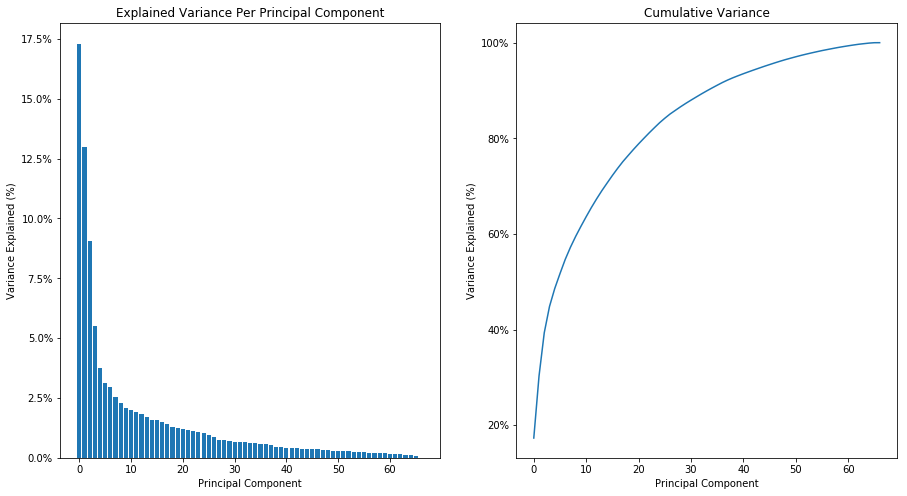

In [53]:
# Investigate the variance accounted for by each principal component.
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

n_component = range(len(azdias_pca.explained_variance_ratio_))
axs[0].bar(n_component, azdias_pca.explained_variance_ratio_)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Variance Explained (%)')
axs[0].set_title('Explained Variance Per Principal Component')

axs[1].plot(n_component, np.cumsum(azdias_pca.explained_variance_ratio_))
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Variance Explained (%)')
axs[1].set_title('Cumulative Variance')
    
plt.show() 

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
# To retain 20 components as they are able to explain about 80% of the variances
RETAIN_COMPONENTS = 20
azdias_pca_20 = PCA(n_components=RETAIN_COMPONENTS)
azdias_pca_transformed = azdias_pca_20.fit_transform(azdias_ss_transformed)

### Discussion 2.2: Perform Dimensionality Reduction

After investigate the variance accounted for by each principal component, I had decided to retain 20 components as they are able to explain about 80% of the variances. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells.

# Map weights for the principal component to corresponding feature names
# and then return the linked values, sorted by weight.
def pca_map_feat(n_component):
    return pd.DataFrame(
        azdias_pca_20.components_[n_component-1], 
        columns=['Weight'], 
        index=azdias_ss_transformed.columns).sort_values(by=['Weight'], ascending=False)

In [56]:
# Map weights for the first principal component to corresponding feature names
#and then print the linked values, sorted by weight.
print(pca_map_feat(1).head())
print(pca_map_feat(1).tail())

                          Weight
PLZ8_ANTG3              0.227734
PLZ8_ANTG4              0.222014
PLZ8_BAUMAX             0.217338
CAMEO_INTL_2015_WEALTH  0.203131
ORTSGR_KLS9             0.200428
                     Weight
FINANZ_MINIMALIST -0.201799
KBA05_GBZ         -0.213855
KBA05_ANTG1       -0.220980
PLZ8_ANTG1        -0.227113
MOBI_REGIO        -0.238124


In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_map_feat(2).head())
print(pca_map_feat(2).tail())

                        Weight
ALTERSKATEGORIE_GROB  0.270555
FINANZ_VORSORGER      0.243049
SEMIO_ERL             0.234510
SEMIO_LUST            0.189214
RETOURTYP_BK_S        0.164974
                                Weight
SEMIO_TRADV                  -0.238615
SEMIO_PFLICHT                -0.239672
FINANZ_SPARER                -0.249858
PRAEGENDE_JUGENDJAHRE_DECADE -0.260038
SEMIO_REL                    -0.264179


In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_map_feat(3).head())
print(pca_map_feat(3).tail())

                     Weight
SEMIO_VERT         0.347693
SEMIO_SOZ          0.263604
SEMIO_FAM          0.250363
SEMIO_KULT         0.235216
FINANZ_MINIMALIST  0.161437
              Weight
SEMIO_RAT  -0.216038
SEMIO_KRIT -0.275527
SEMIO_DOM  -0.313629
SEMIO_KAEM -0.338826
ANREDE_KZ  -0.369652


### Discussion 2.3: Interpret Principal Components

#### First Principal Component
In the first principal component, the top 3 weights features are MOBI_REGIO, PLZ8_ANTG3 and PLZ8_ANTG1. These refer to movement patterns, number of 6-10 family houses and number of 1-2 family houses.

The first principal component seems related to the region is either city or suburb based on the movement patterns of the people and the type of housing. 

With large negative weights on movement patterns, number of single-family housing and positive weights on number of multi-family housing (apartments, condos, townhouses, duplexes, and quadruplexes), it indicated the region is a city, with individuals with high movement patterns and large number of apartments, condos, townhouses, duplexes, and quadruplexes.


#### Second Principal Component
In the second principal component, the top 3 weights features are ALTERSKATEGORIE_GROB, SEMIO_REL and PRAEGENDE_JUGENDJAHRE_DECADE. These refer to Estimated age based on given name analysis, Personality typology - religious and 
Dominating movement of person's youth based on decade.

The second principal component seems related to the individual's age and their personality outlook. 

With large positive weights on age and negative weights on religious and the decade the individual lived through, it indicated older people are tends to be more religious.

#### Third Principal Component
In the third principal component, the top 3 weights features are ANREDE_KZ, SEMIO_VERT and SEMIO_KAEM. These refer to Gender, Personality typology - dreamful and Personality typology - combative attitude.

The third principal component seems related to the individual's gender and their personality outlook.

With large negative weights on gender and combative attitude and positive weights on dreamful personality, it indicated male are tends to be more combative and dominant-minded and less of a dreamer.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [59]:
kmeans_scores = []

# Over a number of different cluster counts...   
# Test for 15 cluster counts
for k in range (1, 16):
    # Run k-means clustering on the data and...
    
    # Create an instance of KMeans with k number of clusters and a random state to make the randomness deterministic
    kmeans = KMeans(n_clusters = k, random_state=0) 
    # Run the KMeans algorithm with the pca dataset
    kmeans.fit(azdias_pca_transformed) 
    
    # Compute the Sum of Squared Distances
    kmeans_scores.append(kmeans.inertia_)    

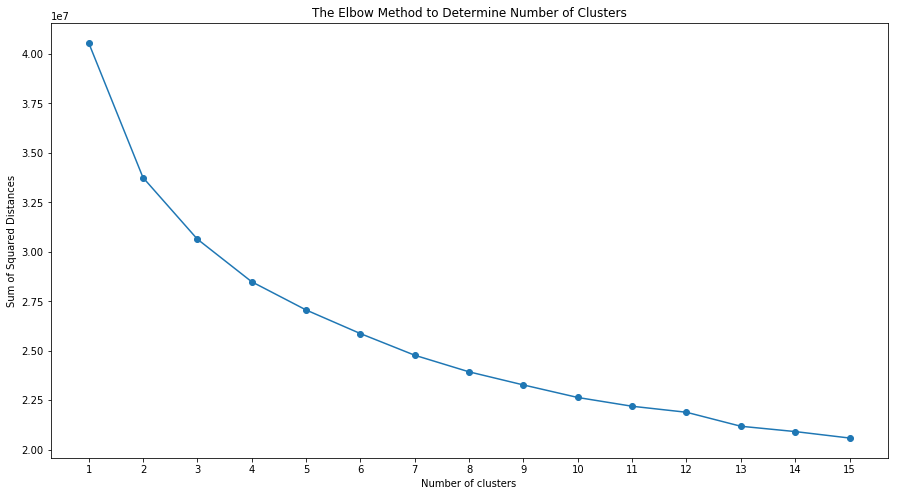

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# To visualize the 'Elbow' to determine the number of clusters
plt.figure(figsize=(15, 8))
plt.plot(range(1, 16), kmeans_scores, '-o')
plt.xticks(range(1, 16))
plt.title('The Elbow Method to Determine Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Creating an instance of the model with optimal number of cluster as 11 based on the Elbow method
kmeans = KMeans(n_clusters = 11, random_state=0) 

# Run the KMeans algorithm with the pca dataset
azdias_kmeans_model = kmeans.fit(azdias_pca_transformed) 

# Predict the azdias pca dataset with the AZDIAS KMeans model and return their labels
azdias_kmeans_pred = azdias_kmeans_model.predict(azdias_pca_transformed)

##### Discussion 3.1: Apply Clustering to General Population

From the above diagram, although there is no definite 'elbow' plotted, I noticed that adding new clusters after cluster 11 will no longer create a substantial decrease in the distance. Therefore, I had decided to segment the population into 11 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

#customers before cleaning
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [63]:
# Cleaning the dataset
customers = clean_data(customers)

#customers after cleaning
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139068 entries, 0 to 191651
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB              138856 non-null float64
ANREDE_KZ                         139068 non-null int64
FINANZ_MINIMALIST                 139068 non-null int64
FINANZ_SPARER                     139068 non-null int64
FINANZ_VORSORGER                  139068 non-null int64
FINANZ_ANLEGER                    139068 non-null int64
FINANZ_UNAUFFAELLIGER             139068 non-null int64
FINANZ_HAUSBAUER                  139068 non-null int64
GREEN_AVANTGARDE                  139068 non-null int64
HEALTH_TYP                        136957 non-null float64
LP_LEBENSPHASE_GROB               130116 non-null float64
RETOURTYP_BK_S                    136332 non-null float64
SEMIO_SOZ                         139068 non-null int64
SEMIO_FAM                         139068 non-null int64
SEMIO_REL                         139068 non-null int64
SEMIO_MAT                         139068 

In [64]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Applying Imputer to replace all NaN values using the mean along the axis
customers_imputer_transformed = pd.DataFrame(azdias_imputer.transform(customers), columns=customers.columns)

In [65]:
# Apply feature scaling to the customer dataset.
customers_ss_transformed = pd.DataFrame(azdias_scaler.transform(customers_imputer_transformed), columns=customers.columns)

In [66]:
# Apply PCA to the dataset while selecting for 20 components to retain.
customers_pca_transformed = azdias_pca_20.transform(customers_ss_transformed)

In [67]:
# Predict the customers pca dataset with the AZDIAS KMeans model and return their labels
customers_kmeans_pred = azdias_kmeans_model.predict(customers_pca_transformed)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

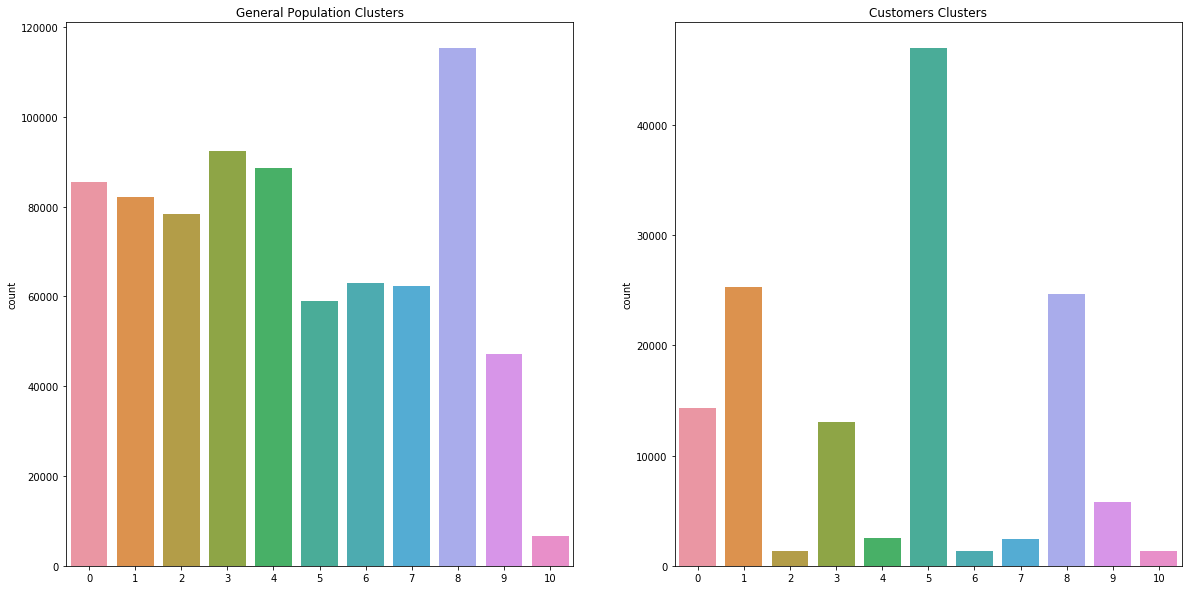

In [68]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

sns.countplot(azdias_kmeans_pred, ax=axs[0]).set_title("General Population Clusters")
sns.countplot(customers_kmeans_pred, ax=axs[1]).set_title("Customers Clusters")
plt.show()

In [69]:
# To find the difference in percentage between the customers clusters and general population clusters
azdias_cluster_precent = []
customers_cluster_percent = []
diff_percent = []

for k in range (0, 11):
    azdias_cluster_precent.append(np.count_nonzero(azdias_kmeans_pred == k) / np.count_nonzero(azdias_kmeans_pred))
    customers_cluster_percent.append(np.count_nonzero(customers_kmeans_pred == k) / np.count_nonzero(customers_kmeans_pred))
    diff_percent.append(customers_cluster_percent[k] - azdias_cluster_precent[k])
    print('Cluster =', k, ', Azdias =', azdias_cluster_precent[k] * 100, ', Customers =', customers_cluster_percent[k] * 100)
    print('Difference =', diff_percent[k] * 100)

Cluster = 0 , Azdias = 12.29440120678413 , Customers = 11.514898803605222
Difference = -0.7795024031789083
Cluster = 1 , Azdias = 11.812925429549802 , Customers = 20.256920165506624
Difference = 8.44399473595682
Cluster = 2 , Azdias = 11.276752852510079 , Customers = 1.0512557333932064
Difference = -10.225497119116872
Cluster = 3 , Azdias = 13.289739024295455 , Customers = 10.500529236295987
Difference = -2.789209787999468
Cluster = 4 , Azdias = 12.745793744125491 , Customers = 1.987843602655804
Difference = -10.757950141469689
Cluster = 5 , Azdias = 8.483041832976125 , Customers = 37.67681303525035
Difference = 29.19377120227422
Cluster = 6 , Azdias = 9.082835424526332 , Customers = 1.0408313821086057
Difference = -8.042004042417727
Cluster = 7 , Azdias = 8.978047871214946 , Customers = 1.9718061391410333
Difference = -7.006241732073913
Cluster = 8 , Azdias = 16.59947116830925 , Customers = 19.74933444526414
Difference = 3.1498632769548895
Cluster = 9 , Azdias = 6.789312245318026 , Cu

In [70]:
# Transform cluster back to original data space
def transform_cluster(cluster):
    # Print all the rows in the dataframe
    pd.set_option("max_rows", None)
    
    print(pd.DataFrame(
        azdias_scaler.inverse_transform(
            azdias_pca_20.inverse_transform(
                azdias_kmeans_model.cluster_centers_[cluster])
        ), columns=['Weight'], index=azdias.columns))

In [71]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# The greatest positive difference between their precentage shows overrepresentation in customers data 
overrepresented_cluster = diff_percent.index(max(diff_percent))

print('Customer cluster', overrepresented_cluster, 'is the most overrepresented')

# Transform the cluster back to original data space for evaluation
transform_cluster(overrepresented_cluster)

Customer cluster 5 is the most overrepresented
                                     Weight
ALTERSKATEGORIE_GROB               3.231887
ANREDE_KZ                          1.085803
FINANZ_MINIMALIST                  4.786690
FINANZ_SPARER                      1.591740
FINANZ_VORSORGER                   4.261629
FINANZ_ANLEGER                     1.454166
FINANZ_UNAUFFAELLIGER              2.188334
FINANZ_HAUSBAUER                   1.988949
GREEN_AVANTGARDE                   0.956808
HEALTH_TYP                         2.050953
LP_LEBENSPHASE_GROB                7.145056
RETOURTYP_BK_S                     3.854140
SEMIO_SOZ                          5.255363
SEMIO_FAM                          4.791343
SEMIO_REL                          3.749256
SEMIO_MAT                          3.751541
SEMIO_VERT                         6.173611
SEMIO_LUST                         5.125541
SEMIO_ERL                          4.085562
SEMIO_KULT                         4.810612
SEMIO_RAT                    

In [73]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# The greatest negative difference between their precentage shows underrepresentation in customers data
underrepresented_cluster = diff_percent.index(min(diff_percent))

print('Customer cluster', underrepresented_cluster, 'is the most underrepresented')

# Transform the cluster back to original data space for evaluation
transform_cluster(underrepresented_cluster)

Customer cluster 4 is the most underrepresented
                                     Weight
ALTERSKATEGORIE_GROB               1.818329
ANREDE_KZ                          1.982125
FINANZ_MINIMALIST                  2.359030
FINANZ_SPARER                      3.922365
FINANZ_VORSORGER                   2.304627
FINANZ_ANLEGER                     4.379561
FINANZ_UNAUFFAELLIGER              3.797752
FINANZ_HAUSBAUER                   2.816162
GREEN_AVANTGARDE                   0.196086
HEALTH_TYP                         2.257885
LP_LEBENSPHASE_GROB                5.414760
RETOURTYP_BK_S                     2.428357
SEMIO_SOZ                          2.999924
SEMIO_FAM                          3.614429
SEMIO_REL                          5.026288
SEMIO_MAT                          4.717768
SEMIO_VERT                         2.564761
SEMIO_LUST                         3.016984
SEMIO_ERL                          4.441876
SEMIO_KULT                         3.926284
SEMIO_RAT                   

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Overrepresented cluster
Cluster 5 is the most overrepresented in the customers dataset. It represented 37.68% in the customer dataset while representing only 8.48% in the general population dataset. A total difference of 29.2%. Therefore, this cluster is the segment of the population that will have the most interests in the services provided by the company. This is the group of individuals that the company should target at.

This customer's cluster is represented mostly by individuals who are male, between 46 and 60 years old and have family with school age children. They usually either save or invest their money but show lack of financial interest. They mostly have very high household income and stay in the West Germany, upper middle class suburb neighbourhoods.

#### Underrepresented cluster
Cluster 4 is the most underrepresented in the customers dataset. It represented only 1.99% in the customer dataset while representing 12.75% in the general population dataset. A total difference of -10.76%. Therefore, this cluster is the segment of the population that will have the least interests in the services provided by the company.

This customer's cluster is represented mostly by individuals who are female, between 30 and 45 years old and have family with school age children. They seldom save or invest their money but show high in financial interest. They mostly have average household income and stay in the West Germany, middle class suburb neighbourhoods.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.